# Interpreting the Projection and Feed-Forward Layers in a Self-Attention Block

> A summary of my experiments to understand the projection layer and feed-forward layer of a self-attention block.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from pathlib import Path
from typing import Dict, Optional, Iterable, Sequence, Tuple

In [ ]:
# | hide

from fastcore.test import *
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# Set a manual seed so output is deterministic (used same value as @karpathy)
_ = torch.manual_seed(1337)

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import aggregate_by_string_key, DataWrapper
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.models.transformer import (
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"device is {device}")

device is cpu


In [ ]:
# Define a block internals experiment with all the unique substrings in the
# Tiny Shakespeare dataset.
s_len = 3
exp = BlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=all_unique_substrings(ts.text, s_len),
)

In [ ]:
# For a specific prompt, print the probabilities of the 10 most likely next tokens
prompt = 'BAP'
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'T' 0.376
'U' 0.296
'H' 0.066
':' 0.060
'E' 0.030
'R' 0.029
' ' 0.019
't' 0.017
'N' 0.017
'C' 0.012


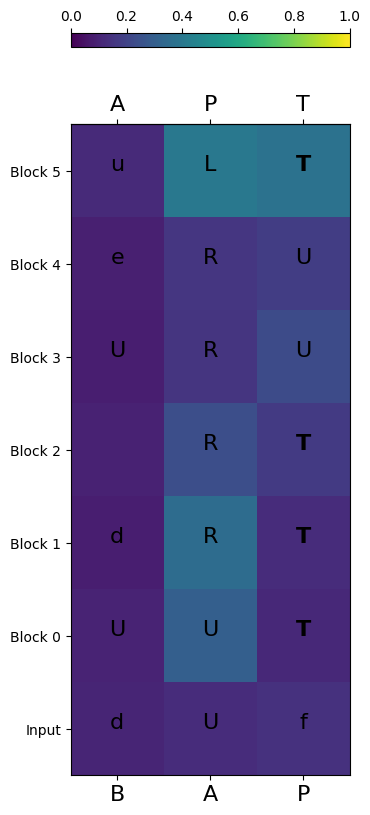

In [ ]:
# Show the logit lens view
logit_lens = LogitLens(encoding_helpers, accessors, 'BAP', 'APT')
logit_lens.plot()

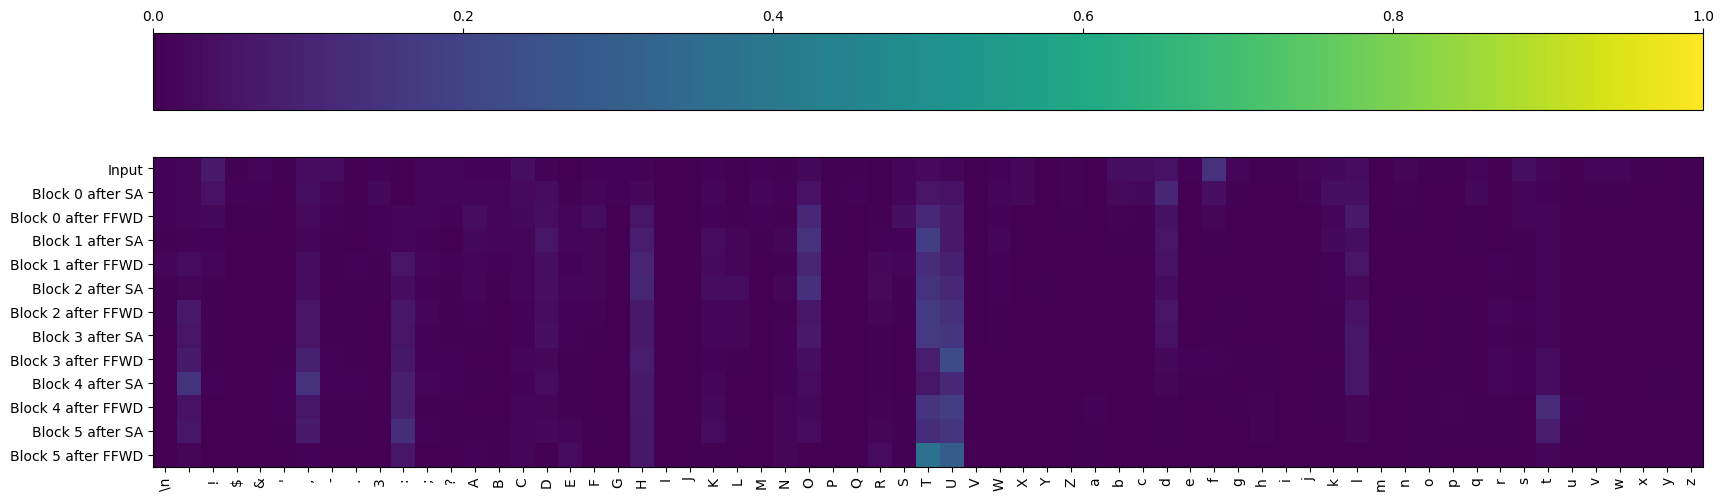

In [ ]:
# Show the block internals view
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt=prompt)
bia.plot()

In [ ]:
# See how it plays out in practice.
prompt = 'BAP'
tokens = encoding_helpers.tokenize_string(prompt)
n_runs = 10
torch.manual_seed(1337)
for _ in range(n_runs):
    print(repr(tokenizer.decode(m.generate(tokens, max_new_tokens=5)[0].tolist())))

'BAPTIS:\n'
'BAPULET:'
'BAPTIS:\n'
'BAPTER:\n'
'BAPTIS:\n'
'BAPULET:'
'BAPTISTE'
'BAPTIS:\n'
'BAP:\nNow'
'BAPULET:'


In [ ]:
def find_topk_similar_values(
    target_value: torch.Tensor,
    all_values: torch.Tensor,
    k: int=10
):
    """Find the top k values in all_values that are closest to target_value."""
    assert all_values.dim() == 2, "all_values must be a 2D tensor"
    assert all_values.shape[1] == target_value.shape[0], (
        "all_values last dimension must equal target_value first dimension"
    )

    distances = torch.norm(all_values - target_value, dim=1)
    topk_distances, topk_indices = torch.topk(distances, k=k, largest=False)
    return topk_distances, topk_indices

In [ ]:
# Get the model's predictions from the input alone.
prompt_idx = exp.string_idx(prompt)
prompt_embedding = exp.embeddings[prompt_idx]

logits = accessors.logits_from_embedding(unsqueeze_emb(prompt_embedding))
logits = LogitsWrapper(logits, tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'f' 0.142
'!' 0.071
'd' 0.047
'c' 0.039
's' 0.039
'b' 0.038
'C' 0.038
',' 0.033
'l' 0.031
'-' 0.031


In [ ]:
# Build a next token map
next_token_map3 = build_next_token_map(
    ts.text, prefix_len=3, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
)

In [ ]:
# Find input embeddings that are similar to the prompt embedding
B, _, _ = exp.embeddings.shape

topk_distances, topk_indices = find_topk_similar_values(
    target_value=prompt_embedding.reshape(-1),
    all_values=exp.embeddings.reshape(B, -1),
    k=10
)

prompt_embedding.reshape(-1).shape, exp.embeddings.reshape(B, -1).shape
similar_strings = [exp.strings[i.item()] for i in topk_indices]

analysis = SubstringFrequencyAnalysis(
    similar_strings,
    next_token_map3,
    tokenizer.itos,
)
analysis.print_summary()

freqs = analysis.cumulative_freqs
top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)

Substrings: 'BAP', 'BAN', 'CAP', 'BAL', 'BAR', 'BAG', 'BAS', 'Bap', 'Bal', 'Bag'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'BAN':  ':' (   6)
   'CAP':  'U' (  95)
   'BAL':  'T' (  29)
   'BAR':  'N' (   7)
   'BAG':  'O' (   6)
   'BAS':  'T' (  42)
   'Bap':  't' (  30)
   'Bal':  't' (   1),  'm' (   1),  'k' (   1)
   'Bag':  'o' (   6)
Cumulative Top Tokens:
 'T' (0.48),  'U' (0.33),  't' (0.11),  'N' (0.02),  ':' (0.02),  'O' (0.02),  'o' (0.02),  'm' (0.00),  'k' (0.00)


[('T', 0.47602739930152893),
 ('U', 0.32534247636795044),
 ('t', 0.10616438090801239),
 ('N', 0.02397260256111622),
 (':', 0.02054794505238533),
 ('O', 0.02054794505238533),
 ('o', 0.02054794505238533),
 ('m', 0.0034246575087308884),
 ('k', 0.0034246575087308884)]

In [ ]:
prompt_idx = exp.string_idx(prompt)

proj_similars = []
proj_distances = []
ffwd_similars = []
ffwd_distances = []
for block_idx in range(n_layer):
    # Find the most similar proj outputs to the prompt
    proj_outputs = exp.proj_output(block_idx=block_idx)[:, -1]
    prompt_proj_output = proj_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_proj_output,
        all_values=proj_outputs,
        k=10,
    )
    similar_strings = [exp.strings[i.item()] for i in topk_indices]
    proj_similars.append(similar_strings)
    proj_distances.append(topk_distances)

    # Find the most similar ffwd outputs to the prompt
    ffwd_outputs = exp.ffwd_output(block_idx=block_idx)[:, -1]
    prompt_ffwd_output = ffwd_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_ffwd_output,
        all_values=ffwd_outputs,
        k=10,
    )
    similar_strings = [exp.strings[i.item()] for i in topk_indices]
    ffwd_similars.append(similar_strings)
    ffwd_distances.append(topk_distances)

In [ ]:
proj_similars, proj_distances

([['BAP', 'BAN', 'CAP', 'SAB', 'ZAB', '\nAB', 'BAL', ' AN', 'BAS', 'CAM'],
  ['BAP', 'BAN', 'BAR', 'BAS', 'BAL', 'BAG', 'Bac', 'Bas', 'Bad', 'Bag'],
  ['BAP', 'BAL', 'BAS', 'BAN', 'BAR', 'BAG', 'Bag', 'Bad', 'Ban', 'Bac'],
  ['BAP', 'BAN', 'BAG', 'BAS', 'BAL', 'BAR', 'BRA', "By'", 'Bay', 'Aba'],
  ['BAP', 'BAL', 'Bap', 'Bal', 'Bar', 'Boo', 'Bas', 'Bor', 'Bou', 'BAN'],
  ['BAP', 'BAS', 'BAR', 'BAL', 'BIS', 'But', 'BAG', 'Bov', 'BAN', 'Bis']],
 [tensor([0.0000, 2.6740, 3.0732, 3.0775, 3.1909, 3.3183, 3.3388, 3.5372, 3.7243,
          3.8754]),
  tensor([0.0000, 1.4399, 1.5282, 1.7506, 1.7877, 1.8182, 4.9871, 5.1028, 5.1815,
          5.1832]),
  tensor([0.0000, 2.1242, 2.2747, 2.3836, 2.4477, 3.4191, 4.1406, 4.2563, 4.3822,
          4.3824]),
  tensor([0.0000, 3.0834, 3.2525, 3.2979, 3.5543, 4.2748, 5.5574, 5.7777, 5.8512,
          5.8894]),
  tensor([0.0000, 3.0785, 3.0967, 3.1707, 3.2126, 3.3210, 3.3273, 3.3452, 3.3544,
          3.3825]),
  tensor([0.0000, 2.1212, 3.1185, 3.1313, 3.

In [ ]:
ffwd_similars, ffwd_distances

([['BAP', 'CAP', 'AMP', 'TEP', 'SEP', 'MOP', 'HOP', 'OMP', 'TOP', 'OOP'],
  ['BAP', 'CAP', 'MOP', 'TOP', 'SEP', 'TEP', 'HOP', 'AMP', 'OOP', 'OSP'],
  ['BAP', 'CAP', 'BAN', 'MOP', 'AMP', 'LAN', 'TOP', 'BAR', 'CAM', 'TEP'],
  ['BAP', 'BAL', 'BAR', 'CAP', 'BAG', 'ABE', 'Abe', 'BAN', 'abe', 'AMP'],
  ['BAP', 'BAL', 'CAP', 'DAM', 'BAG', 'bap', 'BAR', 'sep', 'Daz', 'epe'],
  ['BAP', 'BAS', 'OOP', 'bap', 'rap', 'Bap', ' Aj', 'orp', 'TOP', 'CAP']],
 [tensor([0.0000, 0.6644, 2.0406, 2.0776, 2.2129, 2.2171, 2.2722, 2.3273, 2.4016,
          2.6918]),
  tensor([0.0000, 3.5556, 5.6887, 5.7952, 5.9396, 5.9930, 6.1169, 6.2552, 6.6985,
          6.9018]),
  tensor([0.0000, 6.5570, 7.8843, 7.9948, 8.2203, 8.5468, 8.6237, 8.6576, 8.6716,
          8.6961]),
  tensor([ 0.0000,  9.7076,  9.7220,  9.8370,  9.8444,  9.8473,  9.9139,  9.9200,
           9.9386, 10.0016]),
  tensor([ 0.0000, 10.0889, 10.4197, 10.6212, 10.7716, 10.7758, 10.8574, 11.0253,
          11.0407, 11.0955]),
  tensor([ 0.0000, 12.949

In [ ]:
for similars in proj_similars:
    analysis = SubstringFrequencyAnalysis(
        similars,
        next_token_map3,
        tokenizer.itos,
    )
    analysis.print_summary()
    freqs += analysis.cumulative_freqs

Substrings: 'BAP', 'BAN', 'CAP', 'SAB', 'ZAB', '\nAB', 'BAL', ' AN', 'BAS', 'CAM'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'BAN':  ':' (   6)
   'CAP':  'U' (  95)
   'SAB':  'E' ( 129)
   'ZAB':  'E' ( 105)
  '\nAB':  'H' (  13),  'R' (   5)
   'BAL':  'T' (  29)
   ' AN':  'N' (  51)
   'BAS':  'T' (  42)
   'CAM':  'I' (  72)
Cumulative Top Tokens:
 'E' (0.38),  'T' (0.23),  'U' (0.15),  'I' (0.12),  'N' (0.08),  'H' (0.02),  ':' (0.01),  'R' (0.01)
Substrings: 'BAP', 'BAN', 'BAR', 'BAS', 'BAL', 'BAG', 'Bac', 'Bas', 'Bad', 'Bag'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'BAN':  ':' (   6)
   'BAR':  'N' (   7)
   'BAS':  'T' (  42)
   'BAL':  'T' (  29)
   'BAG':  'O' (   6)
   'Bac':  'k' (   4),  'c' (   1)
   'Bas':  'e' (   3),  't' (   2),  'i' (   1)
   'Bad':  ' ' (   4),  'e' (   1)
   'Bag':  'o' (   6)
Cumulative Top Tokens:
 'T' (0.77),  'N' (0.04),  ':' (0.03),  'o' (0.03),  'O' (0.03),  'k' (0.02),  'e' (0.02),  ' ' (0.02),  't' (0.01),  'c'

In [ ]:
for similars in ffwd_similars:
    analysis = SubstringFrequencyAnalysis(
        similars,
        next_token_map3,
        tokenizer.itos,
    )
    analysis.print_summary()
    freqs += analysis.cumulative_freqs

Substrings: 'BAP', 'CAP', 'AMP', 'TEP', 'SEP', 'MOP', 'HOP', 'OMP', 'TOP', 'OOP'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'CAP':  'U' (  95)
   'AMP':  'S' (  20)
   'TEP':  'H' (   6)
   'SEP':  'H' (   1)
   'MOP':  'S' (  13)
   'HOP':  ' ' (  17)
   'OMP':  'E' (  58),  'H' (   2)
   'TOP':  'H' (   2)
   'OOP':  ':' (   6)
Cumulative Top Tokens:
 'U' (0.33),  'T' (0.24),  'E' (0.20),  'S' (0.11),  ' ' (0.06),  'H' (0.04),  ':' (0.02)
Substrings: 'BAP', 'CAP', 'MOP', 'TOP', 'SEP', 'TEP', 'HOP', 'AMP', 'OOP', 'OSP'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'CAP':  'U' (  95)
   'MOP':  'S' (  13)
   'TOP':  'H' (   2)
   'SEP':  'H' (   1)
   'TEP':  'H' (   6)
   'HOP':  ' ' (  17)
   'AMP':  'S' (  20)
   'OOP':  ':' (   6)
   'OSP':  'E' (  63)
Cumulative Top Tokens:
 'U' (0.33),  'T' (0.23),  'E' (0.22),  'S' (0.11),  ' ' (0.06),  'H' (0.03),  ':' (0.02)
Substrings: 'BAP', 'CAP', 'BAN', 'MOP', 'AMP', 'LAN', 'TOP', 'BAR', 'CAM', 'TEP'
Top Tokens for e

In [ ]:
top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)

[('T', 0.3333333432674408),
 ('U', 0.19797064363956451),
 (' ', 0.1256476640701294),
 ('E', 0.07664076238870621),
 ('I', 0.031088082119822502),
 ('L', 0.027849741280078888),
 ('t', 0.02590673603117466),
 ('S', 0.025690846145153046),
 ('N', 0.023100173100829124),
 (':', 0.01619170978665352),
 (',', 0.01619170978665352),
 ('D', 0.01424870453774929),
 ('H', 0.014032815583050251),
 ('n', 0.01165803149342537),
 ('O', 0.009067357517778873),
 ('r', 0.00863557867705822),
 ('l', 0.006692573428153992),
 ('o', 0.004533678758889437),
 ('e', 0.0038860102649778128),
 ('a', 0.0038860102649778128),
 ('K', 0.0034542314242571592),
 ('i', 0.0030224525835365057),
 ('Y', 0.0028065629303455353),
 ('s', 0.0028065629303455353),
 ('k', 0.0023747840896248817),
 ('h', 0.002158894669264555),
 ('u', 0.0017271157121285796),
 ('R', 0.0010794473346322775),
 ('\n', 0.0008635578560642898),
 ('c', 0.0006476683774963021),
 ('d', 0.0006476683774963021),
 ('p', 0.0004317789280321449),
 ('.', 0.0004317789280321449),
 ('b', 

In [ ]:
def simulate(
    prompt: str,
    exp: BlockInternalsExperiment,
    encoding_helpers: EncodingHelpers,
    accessors: TransformerAccessors,
    next_token_map: Dict[str, torch.Tensor],
):
    tokenizer = encoding_helpers.tokenizer

    def freqs_from_similar_strings(similar_strings: Iterable[str]):
        analysis = SubstringFrequencyAnalysis(
            similar_strings, next_token_map, tokenizer.itos
        )
        return analysis.cumulative_freqs

    def get_similar_strings(
        target_value: torch.Tensor,
        all_values: torch.Tensor,
        k: int=10
    ):
        _, topk_indices = find_topk_similar_values(
            target_value=target_value,
            all_values=all_values,
            k=k,
        )
        return [exp.strings[i.item()] for i in topk_indices]

    n_similars = 10

    # Run the prompt through the model so we can get all the
    # intermediate values for the prompt. The prompt may not
    # have been in the experiment's strings, so we need to
    # do this.
    tokens = encoding_helpers.tokenize_string(prompt)
    prompt_embedding = accessors.embed_tokens(tokens)

    _, prompt_io_accessors = accessors.run_model(prompt_embedding)

    # Find input embeddings that are similar to the prompt embedding
    B, _, _ = exp.embeddings.shape

    similar_strings = get_similar_strings(
        target_value=prompt_embedding[0].reshape(-1),
        all_values=exp.embeddings.reshape(B, -1),
        k=n_similars,
    )
    freqs = freqs_from_similar_strings(similar_strings)

    for block_idx in range(n_layer):
        # Find the most similar proj outputs to the prompt
        proj_outputs = exp.proj_output(block_idx=block_idx)[:, -1]
        prompt_proj_output = prompt_io_accessors[block_idx].output('sa.proj')[0][-1]
        similar_strings = get_similar_strings(
            target_value=prompt_proj_output,
            all_values=proj_outputs,
            k=n_similars,
        )
        freqs += freqs_from_similar_strings(similar_strings)

        # Find the most similar ffwd outputs to the prompt
        ffwd_outputs = exp.ffwd_output(block_idx=block_idx)[:, -1]
        prompt_ffwd_output = prompt_io_accessors[block_idx].output('ffwd')[0][-1]
        similar_strings = get_similar_strings(
            target_value=prompt_ffwd_output,
            all_values=ffwd_outputs,
            k=n_similars,
        )
        freqs += (1 + block_idx) * freqs_from_similar_strings(similar_strings)

    # Compute the model's predictions:
    tokens = encoding_helpers.tokenize_string(prompt)
    logits, _ = m(tokens)
    logits = LogitsWrapper(logits, tokenizer)
    return top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)[:10], logits.topk_tokens(k=10)[0][-1]

In [ ]:
simulate('BAP', exp, encoding_helpers, accessors, next_token_map3)

([('T', 0.3243669271469116),
  ('U', 0.2630801200866699),
  (' ', 0.0607941672205925),
  ('L', 0.05084244906902313),
  ('E', 0.04118632525205612),
  ('t', 0.03379643335938454),
  ('I', 0.02837718091905117),
  ('S', 0.027391862124204636),
  ('D', 0.019509311765432358),
  ('r', 0.018425460904836655)],
 [('T', 0.3757534921169281),
  ('U', 0.29568296670913696),
  ('H', 0.06634116172790527),
  (':', 0.06012270599603653),
  ('E', 0.029964493587613106),
  ('R', 0.029182784259319305),
  (' ', 0.018561311066150665),
  ('t', 0.016756560653448105),
  ('N', 0.016713792458176613),
  ('C', 0.01194547489285469)])

In [ ]:
simulate('Fir', exp, encoding_helpers, accessors, next_token_map3)

([('s', 0.5759245753288269),
  ('e', 0.15355785191059113),
  (' ', 0.04927520081400871),
  ('m', 0.03891307860612869),
  (',', 0.038086313754320145),
  ('t', 0.028275368735194206),
  ('i', 0.028220249339938164),
  ('d', 0.017527421936392784),
  ('l', 0.012181006371974945),
  ('r', 0.012125888839364052)],
 [('s', 0.9917504191398621),
  (' ', 0.0029867461416870356),
  ('m', 0.002403548453003168),
  ('e', 0.001212369417771697),
  ('d', 0.0005165351321920753),
  ('t', 0.00018800597172230482),
  (',', 0.00016302602307405323),
  (':', 7.246402674354613e-05),
  ('g', 6.890708755236119e-05),
  ('z', 6.84931583236903e-05)])

In [ ]:
simulate('Cit', exp, encoding_helpers, accessors, next_token_map3)

([('i', 0.30492648482322693),
  ('y', 0.19287854433059692),
  ('h', 0.16563305258750916),
  ('e', 0.11358093470335007),
  (' ', 0.05365479737520218),
  ('t', 0.029823705554008484),
  ('I', 0.0194411538541317),
  ('s', 0.017768796533346176),
  ('o', 0.017281025648117065),
  ('c', 0.015887394547462463)],
 [('i', 0.8416081666946411),
  ('y', 0.08598577231168747),
  ('e', 0.03443723917007446),
  ('a', 0.012056170031428337),
  ('h', 0.006880255416035652),
  (' ', 0.005409856326878071),
  ('o', 0.003821917809545994),
  ('l', 0.0014970063930377364),
  ('c', 0.001315052853897214),
  ('s', 0.0011799331987276673)])

In [ ]:
simulate('Mar', exp, encoding_helpers, accessors, next_token_map3)

([('r', 0.22357723116874695),
  ('c', 0.15401479601860046),
  ('k', 0.0868731141090393),
  ('v', 0.08198593556880951),
  ('e', 0.06106695905327797),
  ('i', 0.047547273337841034),
  ('t', 0.0471818745136261),
  ('s', 0.047136202454566956),
  ('g', 0.045765962451696396),
  (' ', 0.03676806390285492)],
 [('c', 0.45657357573509216),
  ('g', 0.1392820030450821),
  ('i', 0.09480810910463333),
  ('q', 0.07198260724544525),
  ('r', 0.05351363494992256),
  ('k', 0.03357788920402527),
  ('s', 0.02921028807759285),
  ('t', 0.025271940976381302),
  ('v', 0.020283378660678864),
  ('p', 0.013849235139787197)])

In [ ]:
simulate('arc', exp, encoding_helpers, accessors, next_token_map3)

([('e', 0.22243662178516388),
  (' ', 0.1906214952468872),
  ('h', 0.12730535864830017),
  ('i', 0.11539152264595032),
  (',', 0.047251515090465546),
  ('y', 0.04332510754466057),
  ('a', 0.042158402502536774),
  ('s', 0.036078080534935),
  ('u', 0.029459277167916298),
  ('o', 0.022212250158190727)],
 [('h', 0.8696205615997314),
  ('e', 0.07215109467506409),
  ('i', 0.03782087564468384),
  ('o', 0.006874476559460163),
  ('y', 0.003423927817493677),
  ('a', 0.002202593954280019),
  ('u', 0.0016430942341685295),
  (' ', 0.0013816507998853922),
  ('s', 0.0006439642747864127),
  ('l', 0.0006395326927304268)])

In [ ]:
# Run simulate() on a bunch of random strings and collect the output
n_samples = 1000

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp.strings))[:n_samples]
strings = [exp.strings[i.item()] for i in indices]

results3 = {}
for s in tqdm(strings):
    sim_output, model_output = simulate(s, exp, encoding_helpers, accessors, next_token_map3)
    results3[s] = (sim_output, model_output)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def analyze_simulate_results(results: Dict[str, Tuple[Sequence, Sequence]]):
    n_samples = len(results)
    top1_token_matches_count = 0
    top1_token_match_failures = []

    top2_token_matches_count = 0
    top2_token_match_failures = []

    top3_token_matches_count = 0
    top3_token_match_failures = []

    top1_token_matches_and_top3_tokens_same_count = 0
    top1_token_matches_and_top3_tokens_same_failures = []

    top2_tokens_same_any_order_count = 0
    top2_tokens_same_any_order_failures = []

    top3_tokens_same_any_order_count = 0
    top3_tokens_same_any_order_failures = []

    for s, (sim_output, model_output) in results.items():
        sim_tokens, _ = zip(*sim_output)
        model_tokens, _ = zip(*model_output)
        if sim_tokens[0] == model_tokens[0]:
            top1_token_matches_count += 1
            if set(sim_tokens[:3]) == set(model_tokens[:3]):
                top1_token_matches_and_top3_tokens_same_count += 1
            else:
                top1_token_matches_and_top3_tokens_same_failures.append(s)
        else:
            top1_token_match_failures.append(s)

        if sim_tokens[:2] == model_tokens[:2]:
            top2_token_matches_count += 1
        else:
            top2_token_match_failures.append(s)

        if sim_tokens[:3] == model_tokens[:3]:
            top3_token_matches_count += 1
        else:
            top3_token_match_failures.append(s)

        if set(sim_tokens[:2]) == set(model_tokens[:2]):
            top2_tokens_same_any_order_count += 1
        else:
            top2_tokens_same_any_order_failures.append(s)

        if set(sim_tokens[:3]) == set(model_tokens[:3]):
            top3_tokens_same_any_order_count += 1
        else:
            top3_tokens_same_any_order_failures.append(s)

    print(f"Top 1 token matches: {top1_token_matches_count / n_samples:.3f}")
    print(f"Top 2 token matches: {top2_token_matches_count / n_samples:.3f}")
    print(f"Top 3 token matches: {top3_token_matches_count / n_samples:.3f}")
    print(f"Top 1 token matches and top 3 tokens same: {top1_token_matches_and_top3_tokens_same_count / n_samples:.3f}")
    print(f"Top 2 tokens same (any order): {top2_tokens_same_any_order_count / n_samples:.3f}")
    print(f"Top 3 tokens same (any order): {top3_tokens_same_any_order_count / n_samples:.3f}")

    return top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results3)

Top 1 token matches: 0.597
Top 2 token matches: 0.322
Top 3 token matches: 0.123
Top 1 token matches and top 3 tokens same: 0.171
Top 2 tokens same (any order): 0.405
Top 3 tokens same (any order): 0.243


In [ ]:
# See how this does with longer prompts
exp5 = BlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=all_unique_substrings(ts.text, 5),
)

In [ ]:
next_token_map5 = build_next_token_map(
    ts.text, prefix_len=5, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
)

In [ ]:
simulate('shyam', exp5, encoding_helpers, accessors, next_token_map5)

([('e', 0.524142324924469),
  (' ', 0.13595934212207794),
  (',', 0.10895806550979614),
  ('.', 0.03208386152982712),
  ('b', 0.023189326748251915),
  ('s', 0.019695043563842773),
  ("'", 0.019059721380472183),
  ('\n', 0.01683608628809452),
  ('i', 0.016518425196409225),
  ('p', 0.013341804035007954)],
 [('e', 0.8080525994300842),
  (' ', 0.08855170756578445),
  (',', 0.023519359529018402),
  ('.', 0.017470987513661385),
  ("'", 0.010048294439911842),
  (':', 0.009866581298410892),
  ('p', 0.008247210644185543),
  ('s', 0.007062970660626888),
  (';', 0.005611235275864601),
  ('i', 0.004027177579700947)])

In [ ]:
simulate('ereby', exp5, encoding_helpers, accessors, next_token_map5)

([(' ', 0.4073884189128876),
  (',', 0.2124166190624237),
  ('\n', 0.056439198553562164),
  (';', 0.05079527944326401),
  ('.', 0.04155977442860603),
  ('e', 0.038481272757053375),
  ('l', 0.0292457677423954),
  ('o', 0.028219599276781082),
  (':', 0.027193432673811913),
  ('?', 0.023601846769452095)],
 [(' ', 0.47169485688209534),
  (',', 0.26089540123939514),
  ('.', 0.06965486705303192),
  (':', 0.06214312091469765),
  ('\n', 0.0447605662047863),
  (';', 0.03800647705793381),
  ('?', 0.027084456756711006),
  ('!', 0.019704341888427734),
  ('-', 0.00319221755489707),
  ("'", 0.002469274215400219)])

In [ ]:
# Check if the intermediate values are the same for the 3 and 5 length experiments
bap_idx = exp.string_idx('BAP')
bapti_idx = exp5.string_idx('BAPTI')

block_idx = 3
test_close(exp.block_input(block_idx=block_idx)[bap_idx], exp5.block_input(block_idx=block_idx)[bapti_idx][:3])
test_close(exp.proj_output(block_idx=block_idx)[bap_idx], exp5.proj_output(block_idx=block_idx)[bapti_idx][:3])
test_close(exp.ffwd_output(block_idx=block_idx)[bap_idx], exp5.ffwd_output(block_idx=block_idx)[bapti_idx][:3])
test_close(exp.block_output(block_idx=block_idx)[bap_idx], exp5.block_output(block_idx=block_idx)[bapti_idx][:3])

In [ ]:
prompt = 'ereby'
prompt_idx = exp5.string_idx(prompt)

proj_similars = []
proj_distances = []
ffwd_similars = []
ffwd_distances = []
for block_idx in range(n_layer):
    # Find the most similar proj outputs to the prompt
    proj_outputs = exp5.proj_output(block_idx=block_idx)[:, -1]
    prompt_proj_output = proj_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_proj_output,
        all_values=proj_outputs,
        k=10,
    )
    similar_strings = [exp5.strings[i.item()] for i in topk_indices]
    proj_similars.append(similar_strings)
    proj_distances.append(topk_distances)

    # Find the most similar ffwd outputs to the prompt
    ffwd_outputs = exp5.ffwd_output(block_idx=block_idx)[:, -1]
    prompt_ffwd_output = ffwd_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_ffwd_output,
        all_values=ffwd_outputs,
        k=10,
    )
    similar_strings = [exp5.strings[i.item()] for i in topk_indices]
    ffwd_similars.append(similar_strings)
    ffwd_distances.append(topk_distances)

In [ ]:
proj_similars, proj_distances

([['ereby',
   'eyebr',
   'reybe',
   ' rebe',
   'eyeba',
   'drybe',
   ' reba',
   'raybe',
   '\nrebe',
   'plebe'],
  ['ereby',
   'trebl',
   'elebr',
   'eyeba',
   ' reba',
   '\nrebe',
   '\nrebu',
   'feebl',
   ' rebe',
   'etebo'],
  ['ereby',
   'ereth',
   'ere b',
   'erbea',
   'ereto',
   'ereta',
   'ebels',
   'erewi',
   'eyeba',
   'eebly'],
  ['ereby',
   "erb'd",
   'eremp',
   'erest',
   'eress',
   'eyeba',
   'erely',
   'erend',
   "erea'",
   'eebly'],
  ['ereby',
   'erby.',
   'erely',
   'eres,',
   'ere I',
   'erenc',
   'erewi',
   'ereab',
   'ereso',
   'ebel,'],
  ['ereby',
   'erely',
   'eress',
   'erent',
   'erend',
   'erest',
   'ereft',
   'erect',
   'erers',
   'ereat']],
 [tensor([0.0000, 1.6044, 1.6646, 1.6827, 1.6979, 1.7379, 1.7963, 1.8674, 1.8796,
          1.9694]),
  tensor([0.0000, 3.4034, 3.7892, 3.8900, 4.1882, 4.1937, 4.2143, 4.5618, 4.6131,
          4.6833]),
  tensor([0.0000, 5.4911, 5.5688, 5.7148, 5.7923, 5.8070, 5.8202, 

In [ ]:
ffwd_similars, ffwd_distances

([['ereby',
   'Derby',
   'rosby',
   'desby',
   'tesby',
   'llaby',
   ' Siby',
   ' Liby',
   '-baby',
   'd aby'],
  ['ereby',
   'Derby',
   'desby',
   'tesby',
   'llaby',
   ' Liby',
   'ughby',
   'rosby',
   'd aby',
   ' Siby'],
  ['ereby',
   'Derby',
   'desby',
   'tesby',
   'rosby',
   ' Liby',
   ' Siby',
   'ughby',
   'hobby',
   'd aby'],
  ['ereby',
   'tesby',
   'desby',
   'Derby',
   'rosby',
   'ughby',
   'bbery',
   'llaby',
   'emory',
   'sbury'],
  ['ereby',
   'desby',
   'tesby',
   'enemy',
   'ughby',
   ' espy',
   'd aby',
   'abeth',
   'ebel,',
   'eemly'],
  ['ereby',
   'ughby',
   'chery',
   'ls by',
   'es by',
   'ys by',
   'egory',
   'el by',
   'rs by',
   'icery']],
 [tensor([0.0000, 0.3647, 0.4228, 0.4305, 0.4341, 0.5136, 0.5150, 0.5720, 0.5798,
          0.5856]),
  tensor([0.0000, 2.8526, 3.7321, 3.8184, 3.8346, 3.9576, 3.9813, 4.0179, 4.0477,
          4.2172]),
  tensor([0.0000, 5.6417, 5.8248, 5.9586, 6.8560, 7.7367, 7.7780, 7.7

In [ ]:
# Run simulate() on a bunch of random strings and collect the output
n_samples = 1000

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp5.strings))[:n_samples]
strings = [exp5.strings[i.item()] for i in indices]

results5 = {}
for s in tqdm(strings):
    sim_output, model_output = simulate(s, exp5, encoding_helpers, accessors, next_token_map5)
    results5[s] = (sim_output, model_output)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results5)

Top 1 token matches: 0.770
Top 2 token matches: 0.470
Top 3 token matches: 0.206
Top 1 token matches and top 3 tokens same: 0.272
Top 2 tokens same (any order): 0.565
Top 3 tokens same (any order): 0.361


In [ ]:
len(top1_token_match_failures), len(top3_token_match_failures), len(top1_token_matches_and_top3_tokens_same_failures), len(top3_tokens_same_any_order_failures)

(230, 794, 498, 639)

In [ ]:
idx = 1
print(repr(top1_token_match_failures[idx]))
simulate(top1_token_match_failures[idx], exp5, encoding_helpers, accessors, next_token_map5)

'\n\nMIR'


([('C', 0.3050413131713867),
  ('A', 0.1362859606742859),
  ('I', 0.1307319849729538),
  ('T', 0.11563657224178314),
  ('G', 0.08544573932886124),
  ('E', 0.07448020577430725),
  ('N', 0.02905155159533024),
  (' ', 0.023497579619288445),
  (':', 0.01723155751824379),
  ('D', 0.015237824060022831)],
 [('G', 0.9023593664169312),
  ('C', 0.020130787044763565),
  ('E', 0.01697480119764805),
  ('T', 0.011545127257704735),
  ('S', 0.007779331412166357),
  ('D', 0.006875296588987112),
  ('W', 0.00641448562964797),
  ('I', 0.0059611317701637745),
  ('R', 0.004623779561370611),
  (' ', 0.0033937140833586454)])

In [ ]:
# try with 10000 samples
# Run simulate() on a bunch of random strings and collect the output
n_samples = 10000

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp5.strings))[:n_samples]
strings = [exp5.strings[i.item()] for i in indices]

results5_10k = {}
for s in tqdm(strings):
    sim_output, model_output = simulate(s, exp5, encoding_helpers, accessors, next_token_map5)
    results5_10k[s] = (sim_output, model_output)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results5_10k)

Top 1 token matches: 0.761
Top 2 token matches: 0.437
Top 3 token matches: 0.180
Top 1 token matches and top 3 tokens same: 0.251
Top 2 tokens same (any order): 0.534
Top 3 tokens same (any order): 0.334


In [ ]:
if list(Path('../artifacts/block_internals_results/large_files/slen3/').glob('*')) == []:
    print("Run `make block_internals_slen3_dataset` in the project root to generate the required dataset")

In [ ]:
exp_batch_3 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=exp.strings,
    output_dir=Path('../artifacts/block_internals_results/large_files/slen3/'),
    batch_size=10000,
)
bap = BlockInternalsAccessors('BAP', encoding_helpers, accessors)
block_idx=5
strings, distances = exp_batch_3.strings_with_topk_closest_proj_outputs(
    block_idx=block_idx,
    t_i=-1,
    query=bap.proj_output(block_idx=block_idx)[0][-1],
    k=10,
    largest=False
)
strings, distances

(['BAP', 'BAS', 'BAR', 'BAL', 'BIS', 'But', 'BAG', 'Bov', 'BAN', 'Bis'],
 tensor([0.0000, 2.1212, 3.1185, 3.1313, 3.4366, 3.4834, 3.5196, 3.6359, 3.6490,
         3.6613]))

In [ ]:
strings, distances = exp_batch_3.strings_with_topk_closest_embeddings(
    query=bap.input_embedding()[0],
    k=10,
    largest=False
)
strings, distances

(['BAP', 'BAN', 'CAP', 'BAL', 'BAR', 'BAG', 'BAS', 'Bap', 'Bal', 'Bag'],
 tensor([ 0.0000, 26.6075, 27.1806, 27.7169, 28.1656, 28.3661, 29.2551, 36.3127,
         36.5268, 36.6473]))

In [ ]:
strings, distances = exp_batch_3.strings_with_topk_closest_ffwd_outputs(
    block_idx=2,
    t_i=-1,
    query=bap.ffwd_output(block_idx=2)[0][-1],
    k=10,
    largest=False
)
strings, distances

(['BAP', 'CAP', 'BAN', 'MOP', 'AMP', 'LAN', 'TOP', 'BAR', 'CAM', 'TEP'],
 tensor([0.0000, 6.5570, 7.8843, 7.9948, 8.2203, 8.5468, 8.6237, 8.6576, 8.6716,
         8.6961]))

In [ ]:
def simulate2(
    prompt: str,
    exp: BatchedBlockInternalsExperiment,
    encoding_helpers: EncodingHelpers,
    accessors: TransformerAccessors,
    next_token_map: Dict[str, torch.Tensor],
):
    tokenizer = encoding_helpers.tokenizer

    def freqs_from_similar_strings(similar_strings: Iterable[str]):
        analysis = SubstringFrequencyAnalysis(
            similar_strings, next_token_map, tokenizer.itos
        )
        return analysis.cumulative_freqs

    n_similars = 10

    prompt_accessors = BlockInternalsAccessors(prompt, encoding_helpers, accessors)

    # Find input embeddings that are similar to the prompt embedding
    similar_strings, _ = exp.strings_with_topk_closest_embeddings(
        queries=prompt_accessors.input_embedding(),
        k=n_similars,
        largest=False,
    )
    freqs = freqs_from_similar_strings(similar_strings[0])

    for block_idx in range(n_layer):
        t_i = -1
        # Find the most similar proj outputs to the prompt
        similar_strings, _ = exp.strings_with_topk_closest_proj_outputs(
            block_idx=block_idx,
            t_i=t_i,
            query=prompt_accessors.proj_output(block_idx=block_idx)[0][t_i],
            k=n_similars,
            largest=False
        )
        freqs += freqs_from_similar_strings(similar_strings)

        # Find the most similar ffwd outputs to the prompt
        similar_strings, _ = exp.strings_with_topk_closest_ffwd_outputs(
            block_idx=block_idx,
            t_i=t_i,
            query=prompt_accessors.ffwd_output(block_idx=block_idx)[0][t_i],
            k=n_similars,
            largest=False
        )

        freqs += (1 + block_idx) * freqs_from_similar_strings(similar_strings)

    # Compute the model's predictions:
    tokens = encoding_helpers.tokenize_string(prompt)
    logits, _ = m(tokens)
    logits = LogitsWrapper(logits, tokenizer)
    return top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)[:10], logits.topk_tokens(k=10)[0][-1]

In [ ]:
strings10 = all_unique_substrings(ts.text, 10)

In [ ]:
next_token_map10 = build_next_token_map(
    ts.text, prefix_len=10, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
)

In [ ]:
if list(Path('../artifacts/block_internals_results/large_files/slen10/').glob('*')) == []:
    print("Run `make block_internals_slen10_dataset` in the project root to generate the required dataset")

In [ ]:
exp10 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=strings10,
    output_dir=Path('../artifacts/block_internals_results/large_files/slen10/'),
    batch_size=10000,
)

In [ ]:
strings10[14423:14433]

['more in jo',
 'ore in joy',
 're in joy ',
 'e in joy a',
 ' in joy at',
 'in joy at ',
 'n joy at f',
 ' joy at fi',
 'joy at fir',
 'oy at firs']

In [ ]:
simulate2('First Citi', exp10, encoding_helpers, accessors, next_token_map10)

([('z', 0.9380468726158142),
  ('i', 0.03080154024064541),
  ('e', 0.01610080525279045),
  ('c', 0.004550227429717779),
  ('h', 0.003850192530080676),
  ('p', 0.002100104931741953),
  (':', 0.0014000700321048498),
  ('o', 0.0014000700321048498),
  ('u', 0.0007000350160524249),
  (' ', 0.0007000350160524249)],
 [('z', 0.9996668100357056),
  ('u', 0.00010660554107744247),
  ('I', 7.993520557647571e-05),
  ('U', 2.734881672949996e-05),
  ('K', 2.4257360564661212e-05),
  ('P', 1.5074498151079752e-05),
  ('L', 1.0885321898967959e-05),
  ('n', 8.451069334114436e-06),
  ('O', 8.223939403251279e-06),
  ('f', 7.135453870432684e-06)])

In [ ]:
simulate2('Citizen:\nB', exp10, encoding_helpers, accessors, next_token_map10)

([('e', 0.3421829044818878),
  ('u', 0.17404130101203918),
  ('o', 0.13716813921928406),
  ('h', 0.09587020426988602),
  ('y', 0.08554572612047195),
  ('a', 0.07669616490602493),
  ('n', 0.033923305571079254),
  ('i', 0.028023598715662956),
  ('r', 0.011799409985542297),
  ('t', 0.007374631240963936)],
 [('e', 0.47825106978416443),
  ('u', 0.2509588301181793),
  ('y', 0.1266946792602539),
  ('r', 0.05788085237145424),
  ('i', 0.03135434538125992),
  ('o', 0.02440422773361206),
  ('a', 0.017102370038628578),
  ('l', 0.012891546823084354),
  ('s', 8.761954813962802e-05),
  ('R', 7.359156006714329e-05)])

In [ ]:
simulate2('Shyamalan ', exp10, encoding_helpers, accessors, next_token_map10)

([('t', 0.15815085172653198),
  ('b', 0.1228710487484932),
  ('o', 0.11313868314027786),
  ('a', 0.10340632498264313),
  ('i', 0.09975668787956238),
  ('d', 0.058394160121679306),
  ('s', 0.05352798104286194),
  ('w', 0.04866180196404457),
  ('m', 0.03041362576186657),
  ('f', 0.027980534359812737)],
 [('t', 0.16370470821857452),
  ('s', 0.10785210877656937),
  ('a', 0.09744462370872498),
  ('b', 0.09677103161811829),
  ('c', 0.08353256434202194),
  ('m', 0.056587863713502884),
  ('d', 0.048968441784381866),
  ('p', 0.04876013845205307),
  ('h', 0.04751131683588028),
  ('w', 0.038983285427093506)])

In [ ]:
simulate2('more in jo', exp10, encoding_helpers, accessors, next_token_map10)

([('y', 0.6007066965103149),
  ('t', 0.16607773303985596),
  ('i', 0.07773851603269577),
  ('s', 0.06713780760765076),
  ('u', 0.038869258016347885),
  ('m', 0.017667844891548157),
  ('d', 0.010600706562399864),
  ('r', 0.007067137863487005),
  ('k', 0.0035335689317435026),
  ('l', 0.0035335689317435026)],
 [('y', 0.8568735718727112),
  ('i', 0.06098264083266258),
  ('u', 0.04135835915803909),
  ('c', 0.016126777976751328),
  ('t', 0.012861563824117184),
  ('l', 0.0022685928270220757),
  ('o', 0.0021818610839545727),
  ('s', 0.0016513006994500756),
  ('v', 0.001559981144964695),
  ('w', 0.0011889823945239186)])

In [ ]:
10*60*60 / 40

900.0

In [ ]:
# Run simulate() on a bunch of random strings and collect the output
n_samples = 900

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp10.strings))[:n_samples]
strings = [exp10.strings[i.item()] for i in indices]

results10 = {}
for s in tqdm(strings):
    sim_output, model_output = simulate2(s, exp10, encoding_helpers, accessors, next_token_map10)
    results10[s] = (sim_output, model_output)

  0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results10)

Top 1 token matches: 0.771
Top 2 token matches: 0.376
Top 3 token matches: 0.118
Top 1 token matches and top 3 tokens same: 0.173
Top 2 tokens same (any order): 0.458
Top 3 tokens same (any order): 0.230
